In [1]:
import pandas as pd

In [9]:
english = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/english.csv"
french = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/french.csv"
german = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/german.csv"
italian = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/italian.csv"
japanese = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/japanese.csv"
korean = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/korean.csv"
portuguese = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/portuguese.csv"
russian = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/russian.csv"
spanish = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/spanish.csv"
thai = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/thai.csv"
vietnamese = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/vietnamese.csv"

In [12]:
english_data = pd.read_csv(english)
english_data['class'] = 'english'

french_data = pd.read_csv(french)
french_data['class'] = 'french'

german_data = pd.read_csv(german)
german_data['class'] = 'german'

italian_data = pd.read_csv(italian)
italian_data['class'] = 'italian'

japanese_data = pd.read_csv(japanese)
japanese_data['class'] = 'japanese'

korean_data = pd.read_csv(korean)
korean_data['class'] = 'korean'

portuguese_data = pd.read_csv(portuguese)
portuguese_data['class'] = 'portuguese'

russian_data = pd.read_csv(russian)
russian_data['class'] = 'russian'

spanish_data = pd.read_csv(spanish)
spanish_data['class'] = 'spanish'

thai_data = pd.read_csv(thai)
thai_data['class'] = 'thai'

vietnamese_data = pd.read_csv(vietnamese)
vietnamese_data['class'] = 'vietnamese'

In [13]:
combined_data = pd.concat([english_data, french_data, german_data, italian_data, japanese_data, korean_data, portuguese_data, russian_data, spanish_data, thai_data, vietnamese_data], ignore_index = True)

combined_csv_path = "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/all_dev_data.csv"

combined_data.to_csv(combined_csv_path, index = False)

In [1]:
import json
import csv
import re
import os
import torch
import random
import torchaudio
import torch.nn as nn
import numpy as np
import pandas as pd
from jiwer import wer
from tqdm.auto import tqdm
import torch.nn.functional as F
from IPython.display import Audio
from functools import partial
from torch.utils.data import Dataset

from transformers import Wav2Vec2Model
import torch.nn as nn
from torch.utils.data import DataLoader
# AdamW is best optimizer
from torch.optim import AdamW
from transformers import get_scheduler
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Wav2Vec2FeatureExtractor, Wav2Vec2CTCTokenizer


config = {"VOCAB_PATH" : "/home/IITB/ai-at-ieor/23m1508/Shivam_23M1508/Interspeech/code/model_code/model_files/multilingual_vocab.json",
          "DEVICE" : 0,
          "BASE_MODEL_ID" : "facebook/wav2vec2-xls-r-2b",
          
          "infer_checkpoint_dir" : "/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/checkpoints_mtp/w_till_epoch_1/w_till_epoch_2/multilingual_asr_model_1130000_1150000.pt"}


device = torch.device(f"cuda:{config["DEVICE"]}" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Model Code

In [2]:
# Building the tokenizer
tokenizer = Wav2Vec2CTCTokenizer(config['VOCAB_PATH'],
                                 bos_token = "<s>",
                                 eos_token = "</s>",
                                 unk_token = "<unk>", 
                                 pad_token = "<pad>", 
                                 word_delimiter_token = "|")


feature_extractor = Wav2Vec2FeatureExtractor(feature_size = 1, 
                                             sampling_rate = 16000, 
                                             padding_value = 0.0, 
                                             do_normalize = True, 
                                             return_attention_mask = True)


processor = Wav2Vec2Processor(feature_extractor = feature_extractor, 
                              tokenizer = tokenizer)
# Loaidng the pretrained model

model = Wav2Vec2Model.from_pretrained(config['BASE_MODEL_ID'])

class Projector(nn.Module):
    def __init__(self, model, projection_dim = 5000):
        super().__init__()
        self.wav2vec2 = model
        self.projection = nn.Linear(1920, projection_dim)

    def forward(self, input_values, attention_mask = None):
        outputs = self.wav2vec2(input_values, attention_mask = attention_mask)
        hidden_states = outputs.last_hidden_state  # [batch, time, hidden]
        projected = self.projection(hidden_states)  # [batch, time, 5000]
        return projected


# Custom CTC model
class CustomWav2Vec2CTC(nn.Module):
    def __init__(self, model, vocab_size, projection_dim = 5000):
        super().__init__()

        self.projector = Projector(model, projection_dim = projection_dim)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(projection_dim, vocab_size)

    def forward(self, input_values, attention_mask = None):
        hidden_states = self.projector(input_values, attention_mask)
        hidden_states = self.dropout(hidden_states)
        logits = self.classifier(hidden_states)
        return logits
    
# Path to your JSON file
file_path = config['VOCAB_PATH']

# Open and load JSON data
with open(file_path, "r", encoding="utf-8") as f:
    vocab = json.load(f)

vocab_size = len(vocab)  # your vocab size here
# This is complete model

multilingual_asr_model = CustomWav2Vec2CTC(model, vocab_size = vocab_size)
curr_best_loss = 1000
checkpoint_path = config['infer_checkpoint_dir']

map_location = device

checkpoint = torch.load(checkpoint_path, map_location = 'cpu', weights_only = False)
multilingual_asr_model.load_state_dict(checkpoint['model_state_dict'])
optimizer_state = checkpoint['optimizer_state_dict']
scheduler_state = checkpoint['scheduler_state_dict']
start_epoch = checkpoint['epoch']
curr_best_loss = checkpoint.get('best_loss', curr_best_loss)

print(f"Loaded checkpoint from {checkpoint_path}")
print(f"Resuming at epoch {start_epoch}, best loss: {curr_best_loss:.4f}")
print('Loaded form the previous model: ')
print(f"Loaded checkpoint from {checkpoint_path}")
print(f"Trained till to epoch {start_epoch} with best loss {curr_best_loss:.4f}")
multilingual_asr_model.to(device)

def preprocess_audio(file_path, target_sr = 16000):
    waveform, sample_rate = torchaudio.load(file_path)

    if sample_rate != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
        waveform = resampler(waveform)

    waveform = waveform.squeeze()

    inputs = processor.feature_extractor(
                                            waveform,
                                            sampling_rate=target_sr,
                                            return_tensors="pt"
                                        )
    
    inputs = inputs["input_values"]

    return inputs


def infer(model, file_path):
    
    input_values = preprocess_audio(file_path).to(device)  # (1, time)
    # print('the shape of the input_values is', input_values.shape)

    with torch.no_grad():
        logits = model(input_values)
        log_probs = F.log_softmax(logits, dim = -1)

        predicted_ids = torch.argmax(log_probs, dim = -1)  # (batch, time)

        transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens = True)
        
        return transcription[0]

Loaded checkpoint from /scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/checkpoints_mtp/w_till_epoch_1/w_till_epoch_2/multilingual_asr_model_1130000_1150000.pt
Resuming at epoch 90, best loss: 1.1416
Loaded form the previous model: 
Loaded checkpoint from /scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/checkpoints_mtp/w_till_epoch_1/w_till_epoch_2/multilingual_asr_model_1130000_1150000.pt
Trained till to epoch 90 with best loss 1.1416


### Make inference file

In [3]:
dev_data = pd.read_csv('/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/all_dev_data.csv')

In [4]:
dev_data

,Unnamed: 0.1,Unnamed: 0,ID,Text,Path,class,prediction_0_freeze,Text_normalized,prediction_2_freeze
0,0,0,American-0517_007-O1-000182-000276,"Hi, Ivy.",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,hi ib,hi ivy,hi ib
1,1,1,American-0517_007-O2-000316-000498,"Hi, Carrie, how are you today?",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,hi care realy how are you today,hi carrie how are you today,high care realy how are you today
2,2,2,American-0517_007-O1-000522-000827,"I'm very well, thank you and you?",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,um very wel thank you and you,i'm very well thank you and you,um very wel thank you and you
3,3,3,American-0517_007-O2-000827-001205,"I'm very well thank you for asking, and how wa...",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,im very wel thank you for asking and how was y...,i'm very well thank you for asking and how was...,im very wel thank you for asking and how as yo...
4,4,4,American-0517_007-O1-001243-001957,It was very good uh most of my day I uh spent ...,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,it was very god uh most of my day i uh spent u...,it was very good uh most of my day i uh spent ...,it was very god uh most of my day i uh spent u...
...,...,...,...,...,...,...,...,...,...
29947,29947,29947,0297_001_phone-O2-123892-124090,Bạn có quốc có quyết tâm cùng tôi không.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,bạn có cu có quếtâm củng tôi không,bạn có quốc có quyết tâm cùng tôi không,bảng có cũ có quytâm củng tôi không
29948,29948,29948,0297_001_phone-O1-124090-124540,Quyết tâm quyết tâm quyết tâm chúng ta sẽ mua ...,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,quit tâm uyếtâm quyếtâm chúng ta cmo được ot c...,quyết tâm quyết tâm quyết tâm chúng ta sẽ mua ...,quếtâm quết quếtm chúng t 세ế m được ôtô cho ga...
29949,29949,29949,0297_001_phone-O2-124550-124805,Rồi cảm ơn bạn nhớ chào bạn.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,rồi cả mươn bạn nhờ chảu bạn,rồi cảm ơn bạn nhớ chào bạn,rồi cả mơn bạn nhờ crả bạn
29950,29950,29950,0297_001_phone-O1-124805-124903,Bái bai.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,by bye,bái bai,barby


In [7]:
def run_inference_on_dataframe(df, model, device):
    predictions = []

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Inference Progress"):
        audio_path = row["Path"]

        try:
            transcription = infer(model, audio_path)
        except Exception as e:
            transcription = f"[ERROR: {str(e)}]"
            print(transcription)
        
        predictions.append(transcription.strip())
        
        # GPU cleanup
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    df["prediction_5_freeze"] = predictions
    
    return df

In [8]:
run_inference_on_dataframe(df = dev_data,
                           model = multilingual_asr_model,
                           device = device)

Inference Progress:   0%|          | 0/29952 [00:00<?, ?it/s]

[ERROR: Calculated padded input size per channel: (1). Kernel size: (2). Kernel size can't be greater than actual input size]


,Unnamed: 0.1,Unnamed: 0,ID,Text,Path,class,prediction_0_freeze,Text_normalized,prediction_2_freeze,prediction_5_freeze
0,0,0,American-0517_007-O1-000182-000276,"Hi, Ivy.",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,hi ib,hi ivy,hi ib,hi i v
1,1,1,American-0517_007-O2-000316-000498,"Hi, Carrie, how are you today?",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,hi care realy how are you today,hi carrie how are you today,high care realy how are you today,i care realy how are you today
2,2,2,American-0517_007-O1-000522-000827,"I'm very well, thank you and you?",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,um very wel thank you and you,i'm very well thank you and you,um very wel thank you and you,um very wel thank you and yo
3,3,3,American-0517_007-O2-000827-001205,"I'm very well thank you for asking, and how wa...",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,im very wel thank you for asking and how was y...,i'm very well thank you for asking and how was...,im very wel thank you for asking and how as yo...,im very wel thank you for asking and how was y...
4,4,4,American-0517_007-O1-001243-001957,It was very good uh most of my day I uh spent ...,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,it was very god uh most of my day i uh spent u...,it was very good uh most of my day i uh spent ...,it was very god uh most of my day i uh spent u...,it was very god uh most of my day iuh spent um...
...,...,...,...,...,...,...,...,...,...,...
29947,29947,29947,0297_001_phone-O2-123892-124090,Bạn có quốc có quyết tâm cùng tôi không.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,bạn có cu có quếtâm củng tôi không,bạn có quốc có quyết tâm cùng tôi không,bảng có cũ có quytâm củng tôi không,bàn co고 c quit c ty khog
29948,29948,29948,0297_001_phone-O1-124090-124540,Quyết tâm quyết tâm quyết tâm chúng ta sẽ mua ...,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,quit tâm uyếtâm quyếtâm chúng ta cmo được ot c...,quyết tâm quyết tâm quyết tâm chúng ta sẽ mua ...,quếtâm quết quếtm chúng t 세ế m được ôtô cho ga...,그단 단 q단 중다 세모르 오도저자인
29949,29949,29949,0297_001_phone-O2-124550-124805,Rồi cảm ơn bạn nhớ chào bạn.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,rồi cả mươn bạn nhờ chảu bạn,rồi cảm ơn bạn nhớ chào bạn,rồi cả mơn bạn nhờ crả bạn,r gà mn bạt nhờ chàu bat
29950,29950,29950,0297_001_phone-O1-124805-124903,Bái bai.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,by bye,bái bai,barby,byby


In [9]:
dev_data.to_csv('/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/all_dev_data.csv')

In [11]:
dev_data

,Unnamed: 0.1,Unnamed: 0,ID,Text,Path,class,prediction_0_freeze,Text_normalized,prediction_2_freeze,prediction_5_freeze
0,0,0,American-0517_007-O1-000182-000276,"Hi, Ivy.",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,hi ib,hi ivy,hi ib,hi i v
1,1,1,American-0517_007-O2-000316-000498,"Hi, Carrie, how are you today?",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,hi care realy how are you today,hi carrie how are you today,high care realy how are you today,i care realy how are you today
2,2,2,American-0517_007-O1-000522-000827,"I'm very well, thank you and you?",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,um very wel thank you and you,i'm very well thank you and you,um very wel thank you and you,um very wel thank you and yo
3,3,3,American-0517_007-O2-000827-001205,"I'm very well thank you for asking, and how wa...",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,im very wel thank you for asking and how was y...,i'm very well thank you for asking and how was...,im very wel thank you for asking and how as yo...,im very wel thank you for asking and how was y...
4,4,4,American-0517_007-O1-001243-001957,It was very good uh most of my day I uh spent ...,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,it was very god uh most of my day i uh spent u...,it was very good uh most of my day i uh spent ...,it was very god uh most of my day i uh spent u...,it was very god uh most of my day iuh spent um...
...,...,...,...,...,...,...,...,...,...,...
29947,29947,29947,0297_001_phone-O2-123892-124090,Bạn có quốc có quyết tâm cùng tôi không.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,bạn có cu có quếtâm củng tôi không,bạn có quốc có quyết tâm cùng tôi không,bảng có cũ có quytâm củng tôi không,bàn co고 c quit c ty khog
29948,29948,29948,0297_001_phone-O1-124090-124540,Quyết tâm quyết tâm quyết tâm chúng ta sẽ mua ...,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,quit tâm uyếtâm quyếtâm chúng ta cmo được ot c...,quyết tâm quyết tâm quyết tâm chúng ta sẽ mua ...,quếtâm quết quếtm chúng t 세ế m được ôtô cho ga...,그단 단 q단 중다 세모르 오도저자인
29949,29949,29949,0297_001_phone-O2-124550-124805,Rồi cảm ơn bạn nhớ chào bạn.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,rồi cả mươn bạn nhờ chảu bạn,rồi cảm ơn bạn nhớ chào bạn,rồi cả mơn bạn nhờ crả bạn,r gà mn bạt nhờ chàu bat
29950,29950,29950,0297_001_phone-O1-124805-124903,Bái bai.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,by bye,bái bai,barby,byby


In [31]:
# import pandas as pd
# import re

# def normalize_text_column(df, text_column='Text'):
#     custom_punctuations = r"!#$%&'()*+,./:;<=>?@[\\]^_`{|}~。、？！・¿¡，"

#     punctuation_pattern = re.compile(f'[{re.escape(custom_punctuations)}]')

#     def normalize(text):
#         text = text.lower()
#         text = punctuation_pattern.sub('', text)
#         text = re.sub(r' +', ' ', text)
#         text = text.lower()
        
#         return text.strip()
    
#     df[text_column + '_normalized'] = df[text_column].apply(normalize)
#     return df

# dev_data.to_csv('/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/all_dev_data.csv')
# dev_data

# dev_data = normalize_text_column(dev_data, text_column='Text')

# dev_data.to_csv('/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/all_dev_data.csv')

In [ ]:
# # Rename column
# dev_data.rename(columns={"prediction": "prediction_0_freeze"}, inplace=True)

# Save to CSV
dev_data.to_csv('/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/all_dev_data.csv')

### Plot WER for all languages From all model inferences

In [1]:
import pandas as pd

In [3]:
dev_inference_data = pd.read_csv('/scratch/IITB/ai-at-ieor/23m1508/23m1508_backup/data_dev_csv/all_dev_data.csv')

In [5]:
dev_inference_data.drop(columns = ['Unnamed: 0.2',	'Unnamed: 0.1',	'Unnamed: 0'], inplace = True)


In [6]:
dev_inference_data

,ID,Text,Path,class,prediction_0_freeze,Text_normalized,prediction_2_freeze,prediction_5_freeze
0,American-0517_007-O1-000182-000276,"Hi, Ivy.",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,hi ib,hi ivy,hi ib,hi i v
1,American-0517_007-O2-000316-000498,"Hi, Carrie, how are you today?",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,hi care realy how are you today,hi carrie how are you today,high care realy how are you today,i care realy how are you today
2,American-0517_007-O1-000522-000827,"I'm very well, thank you and you?",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,um very wel thank you and you,i'm very well thank you and you,um very wel thank you and you,um very wel thank you and yo
3,American-0517_007-O2-000827-001205,"I'm very well thank you for asking, and how wa...",/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,im very wel thank you for asking and how was y...,i'm very well thank you for asking and how was...,im very wel thank you for asking and how as yo...,im very wel thank you for asking and how was y...
4,American-0517_007-O1-001243-001957,It was very good uh most of my day I uh spent ...,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,english,it was very god uh most of my day i uh spent u...,it was very good uh most of my day i uh spent ...,it was very god uh most of my day i uh spent u...,it was very god uh most of my day iuh spent um...
...,...,...,...,...,...,...,...,...
29947,0297_001_phone-O2-123892-124090,Bạn có quốc có quyết tâm cùng tôi không.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,bạn có cu có quếtâm củng tôi không,bạn có quốc có quyết tâm cùng tôi không,bảng có cũ có quytâm củng tôi không,bàn co고 c quit c ty khog
29948,0297_001_phone-O1-124090-124540,Quyết tâm quyết tâm quyết tâm chúng ta sẽ mua ...,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,quit tâm uyếtâm quyếtâm chúng ta cmo được ot c...,quyết tâm quyết tâm quyết tâm chúng ta sẽ mua ...,quếtâm quết quếtm chúng t 세ế m được ôtô cho ga...,그단 단 q단 중다 세모르 오도저자인
29949,0297_001_phone-O2-124550-124805,Rồi cảm ơn bạn nhớ chào bạn.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,rồi cả mươn bạn nhờ chảu bạn,rồi cảm ơn bạn nhớ chào bạn,rồi cả mơn bạn nhờ crả bạn,r gà mn bạt nhờ chàu bat
29950,0297_001_phone-O1-124805-124903,Bái bai.,/scratch/IITB/ai-at-ieor/23m1508/23m1508_backu...,vietnamese,by bye,bái bai,barby,byby


In [7]:
import numpy as np
from jiwer import wer  # install with: pip install jiwer


In [8]:
def compute_wer(reference, hypothesis):
    try:
        return wer(reference, hypothesis)
    except:
        return np.nan


In [9]:
# Add WER columns
dev_inference_data['WER_0'] = dev_inference_data.apply(lambda row: compute_wer(row['Text_normalized'], row['prediction_0_freeze']), axis=1)

dev_inference_data['WER_2'] = dev_inference_data.apply(lambda row: compute_wer(row['Text_normalized'], row['prediction_2_freeze']), axis=1)

dev_inference_data['WER_5'] = dev_inference_data.apply(lambda row: compute_wer(row['Text_normalized'], row['prediction_5_freeze']), axis=1)

In [11]:
# dev_inference_data

In [12]:
grouped_wer = dev_inference_data.groupby('class')[['WER_0', 'WER_2', 'WER_5']].mean().reset_index()

In [13]:
grouped_wer

,class,WER_0,WER_2,WER_5
0,english,0.379279,0.389071,0.364181
1,french,0.486424,0.455527,0.642688
2,german,0.894872,0.777917,0.954160
3,italian,0.575256,0.529171,0.516297
4,japanese,1.079558,1.121299,1.909415
5,korean,0.623743,0.625336,0.679956
6,portuguese,0.614013,0.518918,0.777746
7,russian,0.532532,0.516518,0.897426
8,spanish,0.255284,0.249660,0.350288
9,thai,4.796181,4.686458,4.441178


In [ ]:
grouped_wer.columns = ['Class', 'Prediction_0', 'Prediction_2', 'Prediction_5']
print(grouped_wer)

         Class  Prediction_0  Prediction_2  Prediction_5
0      english      0.379279      0.389071      0.364181
1       french      0.486424      0.455527      0.642688
2       german      0.894872      0.777917      0.954160
3      italian      0.575256      0.529171      0.516297
4     japanese      1.079558      1.121299      1.909415
5       korean      0.623743      0.625336      0.679956
6   portuguese      0.614013      0.518918      0.777746
7      russian      0.532532      0.516518      0.897426
8      spanish      0.255284      0.249660      0.350288
9         thai      4.796181      4.686458      4.441178
10  vietnamese      0.653829      0.638393      0.964073


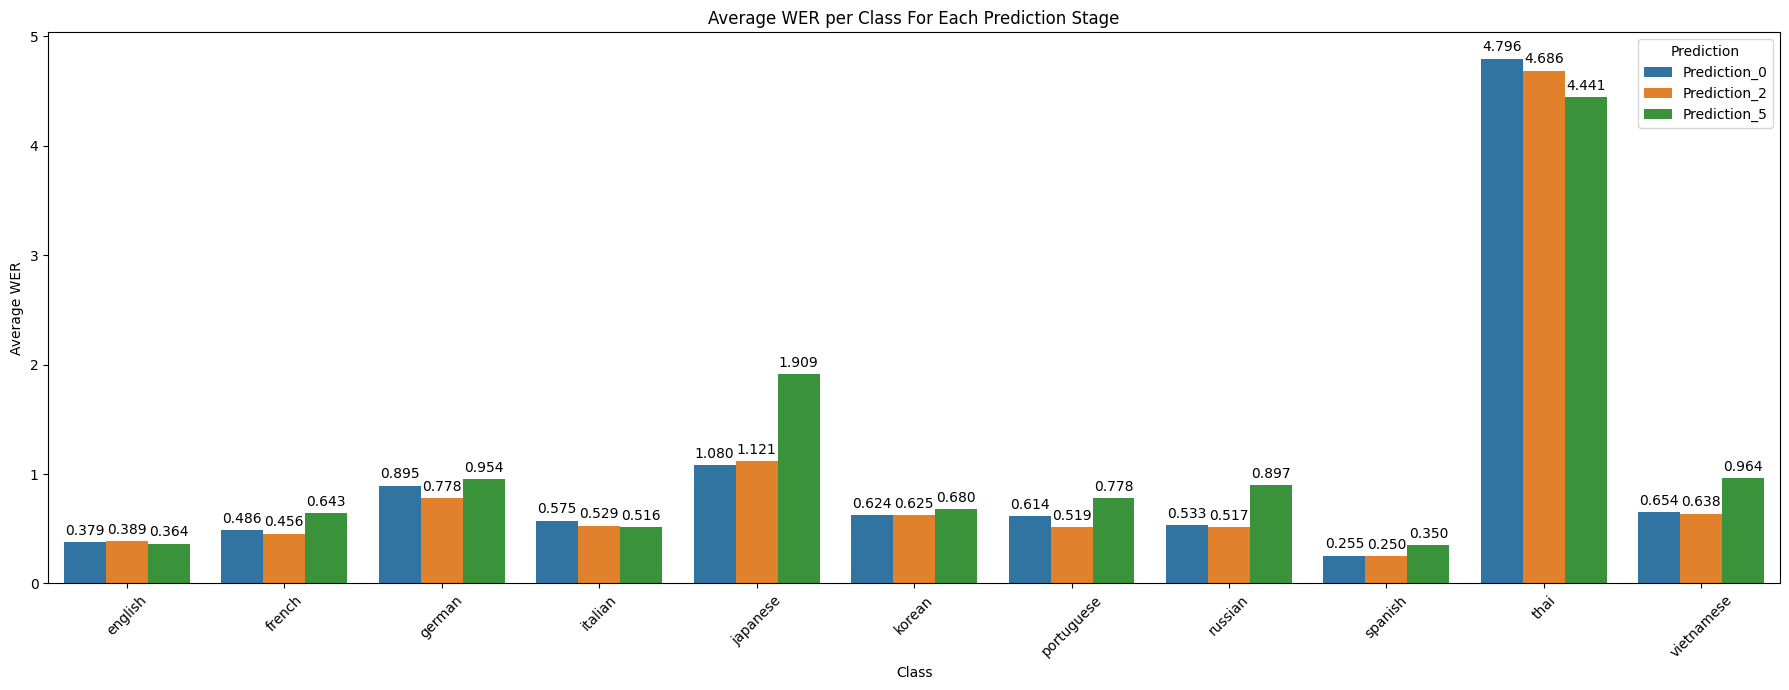

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = grouped_wer.melt(id_vars='Class', var_name='Prediction', value_name='Avg_WER')

plt.figure(figsize=(18, 7))
ax = sns.barplot(data=df_melt, x='Class', y='Avg_WER', hue='Prediction')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=3)

plt.title("Average WER per Class For Each Prediction Stage")
plt.ylabel("Average WER")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
from jiwer import cer

target_classes = ['japanese', 'korean', 'thai']
df_cer = dev_inference_data[dev_inference_data['class'].isin(target_classes)].copy()

In [ ]:
def compute_cer(reference, hypothesis):
    try:
        return cer(reference, hypothesis)
    except:
        return np.nan

df_cer['CER_0'] = df_cer.apply(lambda row: compute_cer(row['Text_normalized'], row['prediction_0_freeze']), axis=1)

df_cer['CER_2'] = df_cer.apply(lambda row: compute_cer(row['Text_normalized'], row['prediction_2_freeze']), axis=1)

df_cer['CER_5'] = df_cer.apply(lambda row: compute_cer(row['Text_normalized'], row['prediction_5_freeze']), axis=1)

In [20]:
grouped_cer = df_cer.groupby('class')[['CER_0', 'CER_2', 'CER_5']].mean().reset_index()

In [21]:
grouped_cer

,class,CER_0,CER_2,CER_5
0,japanese,0.544574,0.527751,0.705186
1,korean,0.341768,0.329069,0.372633
2,thai,1.044592,0.983727,1.028705


In [23]:
grouped_cer.columns = ['Class', 'Prediction_0', 'Prediction_2', 'Prediction_5']
print(grouped_cer)

      Class  Prediction_0  Prediction_2  Prediction_5
0  japanese      0.544574      0.527751      0.705186
1    korean      0.341768      0.329069      0.372633
2      thai      1.044592      0.983727      1.028705


In [27]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# x = grouped_cer['Class']

# plt.plot(x, grouped_cer['Prediction_0'], marker='o', label='Prediction 0 Freeze')
# plt.plot(x, grouped_cer['Prediction_2'], marker='s', label='Prediction 2 Freeze')
# plt.plot(x, grouped_cer['Prediction_5'], marker='^', label='Prediction 5 Freeze')

# plt.title("Average CER per Class (Japanese, Korean, Thai)")
# plt.ylabel("Character Error Rate")
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()


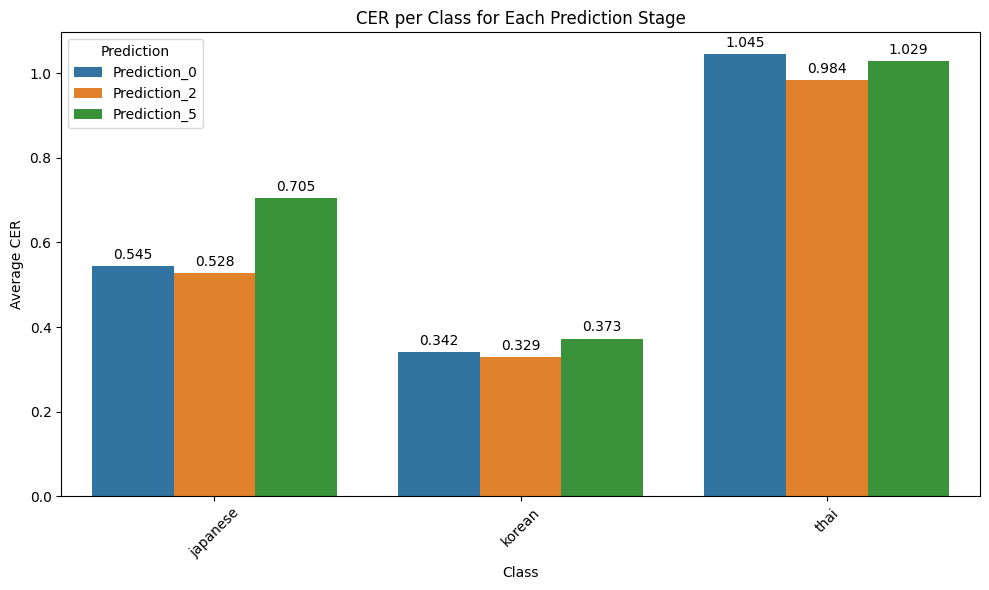

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = grouped_cer.melt(id_vars='Class', var_name='Prediction', value_name='Avg_CER')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melt, x='Class', y='Avg_CER', hue='Prediction')


for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', padding=3)

plt.title("CER per Class for Each Prediction Stage")
plt.ylabel("Average CER")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()